# 1. Settings

In [1]:
# Auto-reload for packages
%load_ext autoreload
%autoreload 2

In [2]:
# Import packages
import pandas as pd
from datetime import datetime
import joblib
import toml

# Import viz tools
from matplotlib import pyplot as plt
import seaborn as sns

# Modelling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Logger
import logging

In [3]:
# Remove warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Configure logger
logging.basicConfig(level = logging.INFO, format = '%(asctime)s :: %(levelname)s :: %(message)s')
logger = logging.getLogger(__name__)

In [5]:
# Import packages
from src.etl.get_data import read_csv_data
from src.etl.get_missing_values import get_df_na, get_na_columns, impute_nan, plot_kdensity
from src.etl.get_train_test_set import get_train_test_set
from src.etl.mlops import string_to_list
from src.ml.get_lasso_model_predictions import get_lasso_model_predictions
from src.ml.get_model_accuracy import get_model_accuracy

In [6]:
# Read config.toml
CONFIG_PATH = './src/config/config.toml'
config = toml.load(CONFIG_PATH)

# Unpack config
DATA_PATH = config['data']['data_path']

# 2. ML Pipeline

## 2.1 Read data

In [7]:
# Read data
df = read_csv_data(DATA_PATH)

2021-08-19 13:55:35,768 :: INFO :: Reading the data from path: df_wine.csv


In [8]:
# Plot info about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6493 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  wine_colour           6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


## 2.2 Missing values

### 2.2.1 Calculate missing values

In [9]:
# Get df with na values
df_na = get_df_na(df)
df_na

2021-08-19 13:55:36,923 :: INFO :: Calculating the nan values for the data
2021-08-19 13:55:36,931 :: INFO :: NumExpr defaulting to 8 threads.


,number_of_nan,number_of_nan_prc
pH,4,0.061567
fixed acidity,0,0.000000
volatile acidity,0,0.000000
citric acid,0,0.000000
residual sugar,0,0.000000
chlorides,0,0.000000
free sulfur dioxide,0,0.000000
total sulfur dioxide,0,0.000000
density,0,0.000000
sulphates,0,0.000000


In [10]:
# Columns with nan values
COLS_TO_IMPUTE = get_na_columns(df_na)
COLS_TO_IMPUTE

2021-08-19 13:55:37,236 :: INFO :: Getting the nan columns that have to be imputed


['pH']

### 2.2.2 Impute nan values

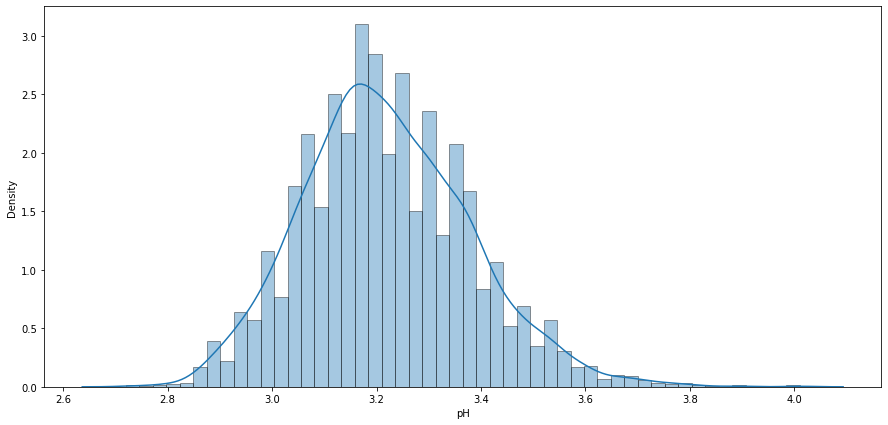

In [11]:
# Plot distribution of the missing columns
plot_kdensity(df, 'pH')

In [12]:
# Impute nan values
df = impute_nan(df, cols = 'pH', replacement = 'mean')

2021-08-19 13:55:38,266 :: INFO :: Impute column: pH, Values filled with the mean: 3.218518404435543
2021-08-19 13:55:38,268 :: INFO :: Imputation completed


## 2.3 Modelling

### 2.3.1 Lasso Logistic regression

In [13]:
# Split data into train and test set
X_train, X_test, y_train, y_test = get_train_test_set(df, response = 'wine_colour', pos_class = 'white')

2021-08-19 13:55:39,199 :: INFO :: Capturing the response col: wine_colour
2021-08-19 13:55:39,202 :: INFO :: Performing binary encoding in the response
2021-08-19 13:55:39,206 :: INFO :: Split the data into train and test set


In [14]:
# Train lasso model & make the predictions
y_pred = get_lasso_model_predictions(X_train, X_test, y_train)

2021-08-19 13:55:39,524 :: INFO :: Training the Lasso Logistic Regression model
2021-08-19 13:55:39,752 :: INFO :: Predict on test set
2021-08-19 13:55:39,755 :: INFO :: Saving model for future use.


# 3. Model evaluation

In [15]:
# Get classification metrics
accuracy = get_model_accuracy(y_test, y_pred)
accuracy

2021-08-19 13:55:40,191 :: INFO :: Getting model accuracy


0.9889230769230769

# 4. Model Drift in Production

In [16]:
# Import model_monitor packages
from src.ml.model_monitor import ModelMonitorReports, MonitorReportReader

In [17]:
# Unpack the config file
LATEST_DRIFT_REPORT = config['json_reports_path']['latest_drift_report_json']
DRIFT_EMAIL_RECEIVER = config['settings']['drift_email_receiver']
PROJECT_NAME = config['settings']['project_name']

REFERENCE_DATA_PATH = config['model_monitor']['reference_data_path']
MODEL_PATH = config['model_monitor']['model_path']

# Take today's data to capture the latest report
today = datetime.today().strftime('%Y%m%d')
LATEST_DRIFT_REPORT_PATH = LATEST_DRIFT_REPORT.format(today=today)

# Have the column mapping as a global parameter
column_mapping = config['model_monitor']['column_mapping'][0]

### Model Performance 

The _"evidently"_ package allows of the following model monitor options: <br><br>
_**1. Data Drift**_ <br>
    Data drift is checking to see if there is any drift between the **independent** variables of the reference & current data. <br><br>
_**2. Target and/or Prediction Drift (a.k.a. Model drift)**_ <br>
Target and/or prediction drift detects if drift occures in the **response** (ground truth) and/or **predictions**. <br><br>
_**3. Performance Monitor**_ <br>
Performance monitor can check for overall **performance** of models for different **metrics** and different segments of data

In [18]:
# As part of the predictions in production, we are expected to use the pre-trained model
lasso_model = joblib.load(MODEL_PATH)

In [19]:
# Create the reference data (with target and predict)
X_train['prediction'] = lasso_model.predict(X_train)
X_train['prediction'] = X_train['prediction'].map({1: 'white', 0: 'red'})

df_reference = pd.concat([X_train, y_train], axis = 1).reset_index(drop=True)
df_reference['wine_colour'] = df_reference['wine_colour'].map({1: 'white', 0: 'red'})
df_reference.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,prediction,wine_colour
0,7.0,0.34,0.26,10.3,0.041,51.0,166.0,0.99382,3.08,0.35,11.6,6,white,white
1,6.4,0.42,0.74,12.8,0.076,48.0,209.0,0.99780,3.12,0.58,9.0,6,white,white
2,7.8,0.53,0.04,1.7,0.076,17.0,31.0,0.99640,3.33,0.56,10.0,6,red,red


In [20]:
# Create the current data (with target and predict)
X_test['prediction'] = lasso_model.predict(X_test)
X_test['prediction'] = X_test['prediction'].map({1: 'white', 0: 'red'})

df_current = pd.concat([X_test, y_test], axis = 1).reset_index(drop=True)
df_current['wine_colour'] = df_current['wine_colour'].map({1: 'white', 0: 'red'})
df_current.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,prediction,wine_colour
0,11.9,0.38,0.51,2.0,0.121,7.0,20.0,0.99960,3.24,0.76,10.4,6,red,red
1,9.0,0.46,0.31,2.8,0.093,19.0,98.0,0.99815,3.32,0.63,9.5,6,red,red
2,7.5,0.20,0.41,1.2,0.050,26.0,131.0,0.99133,3.19,0.52,11.1,5,white,white


_**Column Mapping**_ <br>
Column Mapping is a dictionary that holds information about the data at hand. More specifically, it is a dictionary that shows:
1. Column name of the _response_
2. Column names of the _numerical_ independent variables
3. Column names of the _categorical_ independent variables <br>
These should already be encoded (e.g. one-hot encoded)

For more information, please refer to the "boston_example.ipynb" in the "/src/notebooks/" location

In [21]:
# Check the literal evaluation
column_mapping = config['model_monitor']['column_mapping'][0]
column_mapping

{'target': 'wine_colour',
 'prediction': 'prediction',
 'datetime': [],
 'numerical_features': ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'],
 'categorical_features': []}

In [22]:
# Create the model monitor reports by using the ModelMonitorReports
# Note: The ModelMonitorReports could be imported from ezTools
model_monitor_reports = ModelMonitorReports(df_reference, df_current, column_mapping)
model_monitor_reports

 Welcome to the Model Monitor package! 

                    Available methods: 

                    1. generate_model_data_drift_report()  --> Detects model and/or data drift 

                    2. generate_model_performance_report() --> Generate performance comparison and metrics 

                    3. update_column_mapping()             --> Column mapping that powers the information shown in the visualisations. 
 

                    Enjoy!   
                

In [23]:
# Generate the model performance report
model_monitor_reports.generate_model_performance_report(report_type = 'classification')

2021-08-19 13:55:48,879 :: INFO :: Generating the "classification" report
2021-08-19 13:55:55,055 :: INFO :: Sucess: Report is generated.


_**Usage of the model performance report**_
1. **Analyse the results of a model test:** <br>
Explore the results of an offline test and contrast the different model's performance in an A/B test or shadow model deployment <br>
(possible integration with MLFlow in the future)
2. **To analyze the model performance on the slices of data** <br>
By manipulating the input data frame, you can explore how the model performs on different data segments (e.g. users from a specific region).
3. **To trigger or decide on the model retraining** <br>
You can use this report to check if your performance is below the threshold to initiate a model update and evaluate if retraining is likely to improve performance.
4. **To debug or improve model performance.** <br>
You can use the Classification Quality table to identify underperforming segments and decide on ways to address them.

For more information about the performance reports please address to the following link: <br>
https://docs.evidentlyai.com/reports/classification-performance

#### TO DO

Create the automation part of triggering an alert if any of the metrics degrade below to a pre-specified threshold.

In [24]:
# Idea: Generate a pd.DataFrame that holds the following information:
# ____________________________________________________________
#
#   Metrics  |    Decay (Ref - Curent)    |  Decay Threshold |  Flag
# --------------------------------------------------------------
#  Accuracy   |      2%                    |  3%             |  False
# Sensitivity |      5%                    |  3%             |  True
#    ...      |     ...                    |  ...            |  ...

## 4.1 Production - Day 1

In [25]:
# As part of the predictions in production, we are expected to use the pre-trained model
lasso_model = joblib.load(MODEL_PATH)

In [26]:
# Get the reference data (i.e. data used for training)
df_reference = df.copy()

# Get the production data (i.e. new data that our model is expected to classify in production)
# Note: Data has been stored by Ioannis M. for demonstrating purposes
df_production_day1 = pd.read_pickle('src/data/assets/df_day1.pickle')
df_production_day1.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.3,0.34,0.33,2.5,0.064,21.0,37.0,0.99520,3.35,0.77,12.1,7
1,7.2,0.17,0.37,6.9,0.059,47.0,128.0,0.99322,3.08,0.46,11.0,7
2,7.2,0.40,0.24,8.5,0.055,45.0,151.0,0.99626,3.20,0.52,9.2,5


In [27]:
# Make the prediction on the training data (just for demonstrating purposes)
df_production_day1['prediction'] = lasso_model.predict(df_production_day1)
df_production_day1['prediction'] = df_production_day1['prediction'].map({1: 'white', 0: 'red'})
df_production_day1.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,prediction
0,7.3,0.34,0.33,2.5,0.064,21.0,37.0,0.99520,3.35,0.77,12.1,7,red
1,7.2,0.17,0.37,6.9,0.059,47.0,128.0,0.99322,3.08,0.46,11.0,7,white
2,7.2,0.40,0.24,8.5,0.055,45.0,151.0,0.99626,3.20,0.52,9.2,5,white


In [28]:
# Drop the Target as it is not needed when the ground truth is not available
df_reference.drop('wine_colour', axis=1, inplace=True)

# Make the prediction on the training data (just for demonstrating purposes)
df_reference['prediction'] = lasso_model.predict(df_reference)
df_reference['prediction'] = df_reference['prediction'].map({1: 'white', 0: 'red'})

# Explore how the reference data looks
df_reference.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,prediction
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white


In [29]:
# Explore the column mapping dictionary
column_mapping

{'target': 'wine_colour',
 'prediction': 'prediction',
 'datetime': [],
 'numerical_features': ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'],
 'categorical_features': []}

In [30]:
# Update the column mapping
column_mapping['target'] = None
model_monitor_reports.update_column_mapping(column_mapping)

# Check the updated column mapping
model_monitor_reports.column_mapping

{'target': None,
 'prediction': 'prediction',
 'datetime': [],
 'numerical_features': ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'],
 'categorical_features': []}

In [31]:
# Generate the model & prediction drift in production (e.g. day 1)
model_monitor_reports.generate_model_data_drift_report(response_type = 'categorical', report_name = 'poc')

2021-08-19 13:56:00,838 :: INFO :: Warning: Target is not available in the data
2021-08-19 13:56:00,838 :: INFO :: Generating the data and target/prediction drift
2021-08-19 13:56:03,287 :: INFO :: Sucess: Report is generated.


_**Usage of the data and/or model drift reports**_
1. **Support model maintenance** <br>
Decide on when to retrain the model or which features to drop due to drift.
2. **When debugging model decay** <br>
If the model quality has dropped, the dashboard can help explore where the change comes from.
3. **When no ground truth is available** <br>
You can use this report to check if your performance is below the threshold to initiate a model update and evaluate if retraining is likely to improve performance.
4. **To debug or improve model performance.** <br>
If there is no immediate feedback, the dashboard can be used to explore the changes in the model output and the relationship between the features and prediction.

For more information about the data and model reports please address to the following links: <br>
1. https://docs.evidentlyai.com/reports/classification-performance
2. https://docs.evidentlyai.com/reports/data-drift

In [32]:
# Import the MonitorReportReader class that automates the generation 
# of the automation alter in case drift is detected
monitor_report = MonitorReportReader(LATEST_DRIFT_REPORT_PATH, PROJECT_NAME)
monitor_report

 Welcome to the Monitor Report package! 

                    Available methods: 

                    1. create_data_drift_table()  --> Converts a .json report of data drift to a pd.DataFrame 

                    2. create_model_drift_table() --> Converts a .json report of model drift to a pd.DataFrame 

                    3. send_drift_email_alert()   --> Sends a personalised e-mail to reciepients about detection of drift 
 

                    Enjoy!   
                

In [33]:
# Get the dataframe for data drift that shows if drift is detected
# anywhere in the independent variables
monitor_report.create_data_drift_table()
monitor_report.df_data_drift

2021-08-19 13:56:03,416 :: INFO :: Generating the data drift table


,column_name,p_value,p_value_threshold,drift
0,fixed acidity,0.363897,0.05,Not detected
1,volatile acidity,0.610652,0.05,Not detected
2,citric acid,0.756699,0.05,Not detected
3,residual sugar,0.190253,0.05,Not detected
4,chlorides,0.968060,0.05,Not detected
5,free sulfur dioxide,0.908508,0.05,Not detected
6,total sulfur dioxide,0.786292,0.05,Not detected
7,density,0.785815,0.05,Not detected
8,pH,0.077926,0.05,Not detected
9,sulphates,0.377291,0.05,Not detected


In [34]:
# Generate an e-mail alert if drift is detected "data_drift"
# monitor_report.send_drift_email_alert(DRIFT_EMAIL_RECEIVER, send_for = 'data_drift')

# Note: This needs to be configured from the src/ml/model_monitor.py::MonitorReportReader::send_drift_email_alert
#       For every individual that is using the function - it requires login

In [35]:
# Get the dataframe for model drift that shows if drift is detected
# anywhere in the target/response variables
monitor_report.create_model_drift_table()
monitor_report.df_target_drift

2021-08-19 13:56:08,234 :: INFO :: Generating the model drift table


,drift_column,dtype,p_value,p_value_threshold,drift
0,prediction,cat,0.584203,0.05,Not detected


In [36]:
# Generate an e-mail alert if drift is detected for "model_drift"
# monitor_report.send_drift_email_alert(DRIFT_EMAIL_RECEIVER, send_for = 'model_drift')

# Note: This needs to be configured from the src/ml/model_monitor.py::MonitorReportReader::send_drift_email_alert
#       For every individual that is using the function - it requires login

## Ground Truth - Day 1

In [37]:
# Get the production data (i.e. new data that our model is expected to classify in production)
# Note: Data has been stored by Ioannis M. for demonstrating purposes
df_truth_day1 = pd.read_pickle('./src/data/assets/df_day1_ground_truth.pickle')
df_truth_day1.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_colour
0,7.5,0.29,0.24,9.9,0.058,25.0,115.0,0.99567,3.15,0.46,10.9,5,white
1,6.7,0.23,0.33,8.1,0.048,45.0,176.0,0.99472,3.11,0.52,10.1,6,white
2,6.8,0.63,0.04,1.3,0.058,25.0,133.0,0.99271,3.17,0.39,10.2,4,white


In [38]:
# Make the prediction on the training data (just for demonstrating purposes)
df_truth_day1['prediction'] = lasso_model.predict(df_truth_day1.drop('wine_colour', axis=1))
df_truth_day1['prediction'] = df_truth_day1['prediction'].map({1: 'white', 0: 'red'})
df_truth_day1.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_colour,prediction
0,7.5,0.29,0.24,9.9,0.058,25.0,115.0,0.99567,3.15,0.46,10.9,5,white,white
1,6.7,0.23,0.33,8.1,0.048,45.0,176.0,0.99472,3.11,0.52,10.1,6,white,white
2,6.8,0.63,0.04,1.3,0.058,25.0,133.0,0.99271,3.17,0.39,10.2,4,white,white


In [39]:
# Capture the prediction for the ground truth data
df_reference = df.copy()

df_reference['prediction'] = lasso_model.predict(df_reference.drop('wine_colour', axis=1)) # Drop the response temporarily to predict
df_reference['prediction'] = df_reference['prediction'].map({1: 'white', 0: 'red'})
df_reference.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_colour,prediction
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white,white


In [40]:
# Read the global column_mapping
column_mapping = config['model_monitor']['column_mapping'][0]
column_mapping

{'target': None,
 'prediction': 'prediction',
 'datetime': [],
 'numerical_features': ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'],
 'categorical_features': []}

In [41]:
# Create the model monitor report and generate the data & model dashboard
# for the ground truth day 1
model_monitor_reports = ModelMonitorReports(df_reference, df_truth_day1, column_mapping)
model_monitor_reports.generate_model_data_drift_report(response_type = 'categorical', report_name = 'poc')

2021-08-19 13:56:16,412 :: INFO :: Warning: Target is not available in the data
2021-08-19 13:56:16,413 :: INFO :: Generating the data and target/prediction drift
2021-08-19 13:56:19,010 :: INFO :: Sucess: Report is generated.


In [42]:
# Import the MonitorReportReader class
monitor_report = MonitorReportReader(LATEST_DRIFT_REPORT_PATH, PROJECT_NAME)

In [43]:
# Capture the data drift
monitor_report.create_model_drift_table()
monitor_report.df_target_drift

2021-08-19 13:56:19,133 :: INFO :: Generating the model drift table


,drift_column,dtype,p_value,p_value_threshold,drift
0,prediction,cat,0.302507,0.05,Not detected


In [44]:
# Send alert for model_drift
# monitor_report.send_drift_email_alert(DRIFT_EMAIL_RECEIVER, send_for = 'model_drift')

# Note: This needs to be configured from the src/ml/model_monitor.py::MonitorReportReader::send_drift_email_alert
#       For every individual that is using the function - it requires login

## 4.2 Production - Day 2 (Drift)

In [45]:
# Get the production data (i.e. new data that our model is expected to classify in production)
# Note: Data has been stored by Ioannis M. for demonstrating purposes
df_production_day2 = pd.read_pickle('src/data/assets/df_day2.pickle')
df_production_day2.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,9.40,0.50,0.34,3.6,0.082,5.0,14.0,0.99870,3.29,0.52,10.7,6
1,6.15,0.21,0.37,3.2,0.021,20.0,80.0,0.99076,3.39,0.47,12.0,5
2,8.70,0.23,0.32,13.4,0.044,35.0,169.0,0.99975,3.12,0.47,8.8,7


In [46]:
# Make the prediction on the training data (just for demonstrating purposes)
df_production_day2['prediction'] = lasso_model.predict(df_production_day2)
df_production_day2['prediction'] = df_production_day2['prediction'].map({1: 'white', 0: 'red'})
df_production_day2.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,prediction
0,9.40,0.50,0.34,3.6,0.082,5.0,14.0,0.99870,3.29,0.52,10.7,6,red
1,6.15,0.21,0.37,3.2,0.021,20.0,80.0,0.99076,3.39,0.47,12.0,5,white
2,8.70,0.23,0.32,13.4,0.044,35.0,169.0,0.99975,3.12,0.47,8.8,7,white


In [47]:
# Explore how the reference data looks
df_reference.drop('wine_colour', axis=1, inplace=True)
df_reference.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,prediction
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white


In [48]:
# Update the column mapping
column_mapping['target'] = None
column_mapping

{'target': None,
 'prediction': 'prediction',
 'datetime': [],
 'numerical_features': ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'],
 'categorical_features': []}

In [49]:
# Create the model monitor report and generate the data & model dashboard
# for the production day2
model_monitor_reports = ModelMonitorReports(df_reference, df_production_day2, column_mapping)
model_monitor_reports.generate_model_data_drift_report(response_type = 'categorical', report_name = 'poc')

2021-08-19 13:56:25,924 :: INFO :: Warning: Target is not available in the data
2021-08-19 13:56:25,925 :: INFO :: Generating the data and target/prediction drift
2021-08-19 13:56:28,608 :: INFO :: Sucess: Report is generated.


In [ ]:
# Import the MonitorReportReader class
monitor_report = MonitorReportReader(LATEST_DRIFT_REPORT_PATH, PROJECT_NAME)

In [50]:
# Create the model drift dataframe
monitor_report.create_model_drift_table(response_type = 'categorical', p_value_threshold = 1)
monitor_report.df_target_drift

# Note: We put p_value_threshold = 1 just to create drift on purpose

2021-08-19 13:56:58,589 :: INFO :: Generating the model drift table


,drift_column,dtype,p_value,p_value_threshold,drift
0,prediction,cat,0.271236,1,Detected


In [51]:
# Send an automated e-mail to capture data drift
# monitor_report.send_drift_email_alert(DRIFT_EMAIL_RECEIVER, send_for = 'model_drift')

# Note: This needs to be configured from the src/ml/model_monitor.py::MonitorReportReader::send_drift_email_alert
#       For every individual that is using the function - it requires login

# References

In [ ]:
# https://github.com/evidentlyai/evidently/blob/main/evidently/examples/bicycle_demand_monitoring.ipynb
# https://evidentlyai.com/blog/tutorial-1-model-analytics-in-production
# https://docs.evidentlyai.com/